# Detecting Grape Disease with CNN (Model Building)

## 1. Configuration

### 1.1 Basic Imports

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 1.2 Importing Tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
tf.get_logger().setLevel('ERROR') # set level to only show error messages

### 1.3 VGG16 Imports

In [3]:
from tensorflow.keras.applications import VGG16

### 1.4 Constants

In [4]:
# Constants
batch_size = 32
image_size = 256

### 1.5 Seeds

In [5]:
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## 2. Load Files From EDA 

### 2.1 Load Train, Validation, Test

In [6]:
# load train, validation, test from folder
load_dir = 'datasets/'
train = tf.data.Dataset.load(f'{load_dir}train')
validation = tf.data.Dataset.load(f'{load_dir}validation')
test = tf.data.Dataset.load(f'{load_dir}test')

print(train.element_spec)
print(validation.element_spec)
print(test.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


### 2.2 Pipelines

In [7]:
# ensure images are 265x265 and normalised
resize_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size), # ensure all future images are 256x256
    layers.Rescaling(1.0/255) # normalize data
])

In [8]:
# ensure model learns from different orientations
random_orientations = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25)
])

In [9]:
# ensure model learns from different lighting conditions
lighting = tf.keras.Sequential([
    layers.RandomBrightness(0.05),
])

In [10]:
# manual brightness layer without loops
class RandomBrightnessLayer(layers.Layer): # define custom layer
    def __init__(self, factor=0.25, **kwargs): # initialization of custom layer function
        super(RandomBrightnessLayer, self).__init__(**kwargs)
        self.factor = factor

    def call(self, inputs, training=None): # process input data
        if training:
            delta = tf.random.uniform([], -self.factor, self.factor)
            return tf.image.adjust_brightness(inputs, delta)
        return inputs

## 3. Building CNN's

### 3.1 Model Architecture

In [11]:
# base model
CNN = models.Sequential([
    resize_rescale,
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [12]:
# model with random orientations
CNN_2 = models.Sequential([
    resize_rescale,
    random_orientations,

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [13]:
# model with lighting augmentations
CNN_3 = models.Sequential([
    resize_rescale,
    random_orientations,
    RandomBrightnessLayer(factor=0.25),

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

### 3.2 Model Compiling

In [14]:
# compile CNN1
CNN.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# compile CNN2
CNN_2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# compile CNN3
CNN_3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 4. Fit Models

### 4.1 CNN

In [17]:
%%time
# fit CNN1 and save history
history = CNN.fit(
    train,
    epochs=50,
    verbose=1,
    validation_data=validation
)

Epoch 1/50
141/141 [==============================] - 94s 131ms/step - loss: 0.6907 - accuracy: 0.6933 - val_loss: 0.3344 - val_accuracy: 0.8695
Epoch 2/50
141/141 [==============================] - 13s 88ms/step - loss: 0.2221 - accuracy: 0.9189 - val_loss: 0.1867 - val_accuracy: 0.9412
Epoch 3/50
141/141 [==============================] - 12s 85ms/step - loss: 0.1374 - accuracy: 0.9479 - val_loss: 0.1245 - val_accuracy: 0.9559
Epoch 4/50
141/141 [==============================] - 13s 89ms/step - loss: 0.0790 - accuracy: 0.9710 - val_loss: 0.1284 - val_accuracy: 0.9651
Epoch 5/50
141/141 [==============================] - 12s 86ms/step - loss: 0.0493 - accuracy: 0.9825 - val_loss: 0.1181 - val_accuracy: 0.9632
Epoch 6/50
141/141 [==============================] - 12s 84ms/step - loss: 0.0574 - accuracy: 0.9794 - val_loss: 0.0861 - val_accuracy: 0.9724
Epoch 7/50
141/141 [==============================] - 12s 86ms/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 0.0638 - val_accuracy

### 4.2 CNN_2

In [18]:
%%time
# fit CNN2 and save history
history_2 = CNN_2.fit(
    train,
    epochs=50,
    verbose=1,
    validation_data=validation
)

Epoch 1/50
141/141 [==============================] - 24s 148ms/step - loss: 0.8900 - accuracy: 0.5867 - val_loss: 1.9017 - val_accuracy: 0.5515
Epoch 2/50
141/141 [==============================] - 21s 147ms/step - loss: 0.3514 - accuracy: 0.8626 - val_loss: 0.5067 - val_accuracy: 0.7776
Epoch 3/50
141/141 [==============================] - 21s 149ms/step - loss: 0.2301 - accuracy: 0.9133 - val_loss: 0.3938 - val_accuracy: 0.8585
Epoch 4/50
141/141 [==============================] - 21s 148ms/step - loss: 0.1846 - accuracy: 0.9297 - val_loss: 0.2476 - val_accuracy: 0.9118
Epoch 5/50
141/141 [==============================] - 21s 146ms/step - loss: 0.1243 - accuracy: 0.9566 - val_loss: 0.2563 - val_accuracy: 0.8989
Epoch 6/50
141/141 [==============================] - 21s 147ms/step - loss: 0.1258 - accuracy: 0.9561 - val_loss: 0.3517 - val_accuracy: 0.8585
Epoch 7/50
141/141 [==============================] - 20s 145ms/step - loss: 0.0990 - accuracy: 0.9654 - val_loss: 0.2291 - val_ac

### 4.3 CNN_3

In [19]:
%%time
# fit CNN3 and save history
history_3 = CNN_3.fit(
    train,
    epochs=50,
    verbose=1,
    validation_data=validation
)

Epoch 1/50
141/141 [==============================] - 23s 148ms/step - loss: 1.0667 - accuracy: 0.4998 - val_loss: 0.7172 - val_accuracy: 0.6746
Epoch 2/50
141/141 [==============================] - 20s 144ms/step - loss: 0.5010 - accuracy: 0.7926 - val_loss: 0.6023 - val_accuracy: 0.7610
Epoch 3/50
141/141 [==============================] - 20s 145ms/step - loss: 0.3131 - accuracy: 0.8825 - val_loss: 0.3027 - val_accuracy: 0.8750
Epoch 4/50
141/141 [==============================] - 21s 146ms/step - loss: 0.2173 - accuracy: 0.9211 - val_loss: 0.2721 - val_accuracy: 0.8805
Epoch 5/50
141/141 [==============================] - 20s 144ms/step - loss: 0.1780 - accuracy: 0.9346 - val_loss: 0.2468 - val_accuracy: 0.9099
Epoch 6/50
141/141 [==============================] - 20s 145ms/step - loss: 0.1396 - accuracy: 0.9477 - val_loss: 0.2319 - val_accuracy: 0.9026
Epoch 7/50
141/141 [==============================] - 21s 146ms/step - loss: 0.0983 - accuracy: 0.9637 - val_loss: 0.1863 - val_ac

## 5. VGG16

### 5.1 Model Architecture

In [20]:
# import VGG16 without top
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [21]:
# summary of VGG16
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [22]:
# build VGG_top
VGG_top = models.Sequential()
VGG_top.add(layers.Dense(256, activation='relu', input_dim=8*8*512))
VGG_top.add(layers.Dense(256, activation='relu'))
VGG_top.add(layers.Dense(4, activation='softmax'))

### 5.2 Model Compiling

In [23]:
# compile VGG16_top
VGG_top.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### 5.3 Model Training

In [24]:
# function to train and validate models
def VGG16_train(train, validation):
    VGG_train = VGG16_model.predict(train, verbose=1)
    VGG_validation = VGG16_model.predict(validation, verbose=1)

    VGG_train_flat = np.reshape(VGG_train, (VGG_train.shape[0], 8 * 8 * 512))
    VGG_validation_flat = np.reshape(VGG_validation, (VGG_validation.shape[0], 8 * 8 * 512))

    labels_train = []
    for _, labels in train:
        labels_train.append(labels.numpy())
    labels_train = np.concatenate(labels_train, axis=0)

    labels_validation = []
    for _, labels in validation:
        labels_validation.append(labels.numpy())
    labels_validation = np.concatenate(labels_validation, axis=0)

    history = VGG_top.fit(VGG_train_flat, labels_train, epochs=50, validation_data=(VGG_validation_flat, labels_validation))
    return history

In [25]:
%%time
# save VGG16 history
history_4 = VGG16_train(train, validation)

17/17 [==============================] - 2s 129ms/step
Epoch 1/50
141/141 [==============================] - 1s 6ms/step - loss: 3.8638 - accuracy: 0.9096 - val_loss: 0.3291 - val_accuracy: 0.9706
Epoch 2/50
141/141 [==============================] - 1s 5ms/step - loss: 0.1025 - accuracy: 0.9876 - val_loss: 0.1847 - val_accuracy: 0.9835
Epoch 3/50
141/141 [==============================] - 1s 5ms/step - loss: 0.0890 - accuracy: 0.9907 - val_loss: 0.1064 - val_accuracy: 0.9871
Epoch 4/50
141/141 [==============================] - 1s 6ms/step - loss: 0.0350 - accuracy: 0.9949 - val_loss: 0.2521 - val_accuracy: 0.9816
Epoch 5/50
141/141 [==============================] - 1s 5ms/step - loss: 0.0910 - accuracy: 0.9905 - val_loss: 0.4985 - val_accuracy: 0.9853
Epoch 6/50
141/141 [==============================] - 1s 5ms/step - loss: 0.0857 - accuracy: 0.9934 - val_loss: 0.4794 - val_accuracy: 0.9816
Epoch 7/50
141/141 [==============================] - 1s 5ms/step - loss: 0.0213 - accuracy: 

## 6. Model Evaluation

### 6.1 Gound Up Models

In [26]:
# evaluate CNN1 on testing data
CNN.evaluate(test)

19/19 [==============================] - 2s 88ms/step - loss: 0.0135 - accuracy: 0.9983


[0.013507450930774212, 0.9983498454093933]

In [27]:
# evaluate CNN2 on testing data
CNN_2.evaluate(test)

19/19 [==============================] - 1s 45ms/step - loss: 0.4873 - accuracy: 0.9026


[0.48732832074165344, 0.9026402831077576]

In [28]:
# evaluate CNN3 on testing data
CNN_3.evaluate(test)

19/19 [==============================] - 1s 47ms/step - loss: 0.9313 - accuracy: 0.8581


[0.9312896132469177, 0.8580858111381531]

### 6.2 Transer Learning Model

In [29]:
# functon to evaluate VGG16 on test data
def VGG16_test(df):
    values = VGG16_model.predict(test, verbose=1)
    values_flat = np.reshape(values, (values.shape[0], 8 * 8 * 512))

    labels_list = []
    for _, labels in test:
        labels_list.append(labels.numpy())
    labels = np.concatenate(labels_list, axis=0)

    scores = VGG_top.evaluate(values_flat, labels)
    return scores

In [30]:
# evaluate VGG16 on testing data
VGG16_test(test)

19/19 [==============================] - 0s 6ms/step - loss: 0.2384 - accuracy: 0.9884


[0.23838086426258087, 0.9884488582611084]

## 7. Visulisations

### 7.1 Loss

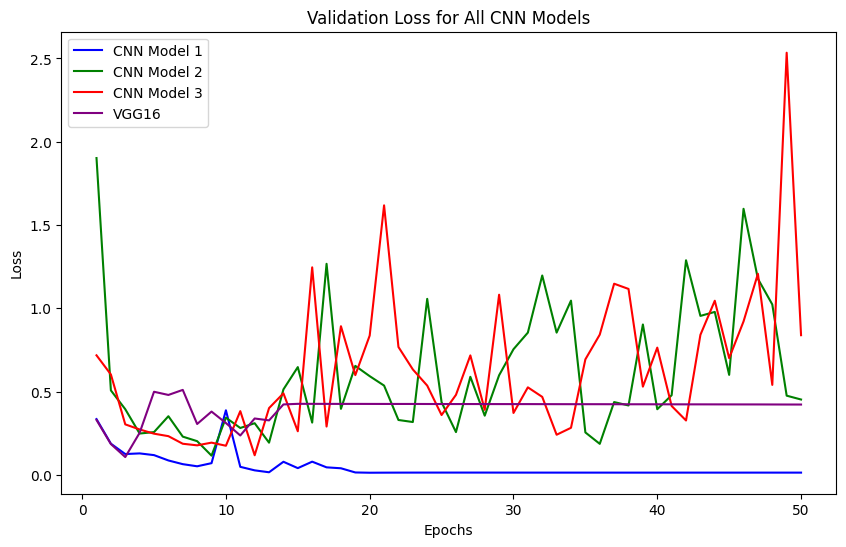

In [31]:
loss1 = history.history['val_loss']
loss2 = history_2.history['val_loss']
loss3 = history_3.history['val_loss']
loss4 = history_4.history['val_loss']

epochs = range(1, len(loss1) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss1, label='CNN Model 1', color='blue')
plt.plot(epochs, loss2, label='CNN Model 2', color='green')
plt.plot(epochs, loss3, label='CNN Model 3', color='red')
plt.plot(epochs, loss4, label='VGG16', color='purple')

plt.title('Validation Loss for All CNN Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Here we can see large fluctuations for CNN_2 and CNN_3​

This is likely due to the random orientations and brightness augmentations added to the training process​

### 7.2 Accuracy

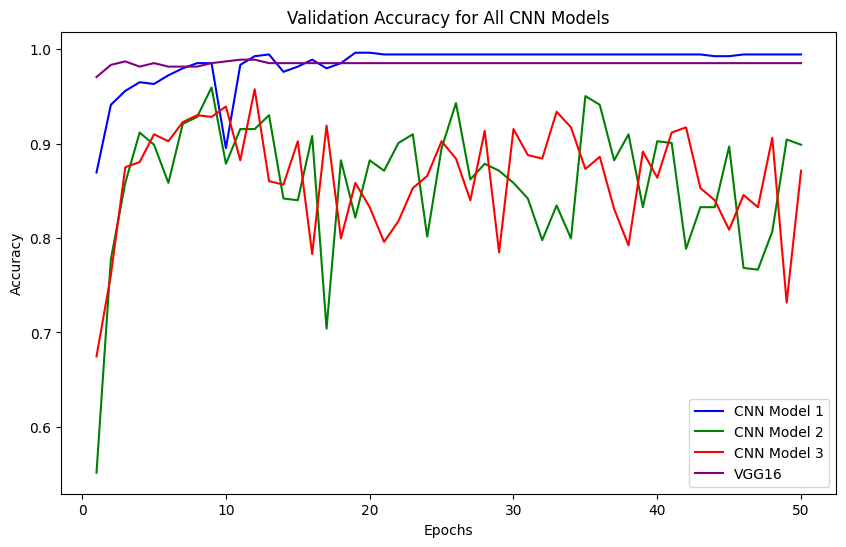

In [32]:
accuracy1 = history.history['val_accuracy']
accuracy2 = history_2.history['val_accuracy']
accuracy3 = history_3.history['val_accuracy']
accuracy4 = history_4.history['val_accuracy']

epochs = range(1, len(accuracy1) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy1, label='CNN Model 1', color='blue')
plt.plot(epochs, accuracy2, label='CNN Model 2', color='green')
plt.plot(epochs, accuracy3, label='CNN Model 3', color='red')
plt.plot(epochs, accuracy4, label='VGG16', color='purple')

plt.title('Validation Accuracy for All CNN Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Here we can see similar fluctuations to the graph above.

VGG16 and CNN_1 leveled out above 0.98 accuracy after 20 epochs

### 8. Confustion Matrix

In [33]:
# function to display Confusion Matrix
def cm(df, model):
    test_pred = model.predict(df)
    test_pred_classes = np.argmax(test_pred, axis=1)
    
    labels = []
    for _, label in df:
        labels.extend(label.numpy())
    labels = np.array(labels).astype(int)

    cm = confusion_matrix(labels, test_pred_classes)
    disp  = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Black Measles', 'Black Rot', 'Healthy', 'Leaf Blight'])
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks()
    plt.show()

### 8.1 CNN_1

19/19 [==============================] - 1s 54ms/step


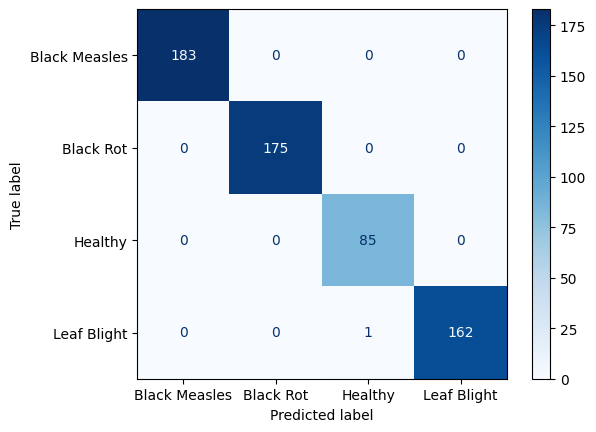

In [34]:
cm(test, CNN)

We can see that CNN_1 wrongly predicted 1 leaf blight leaf as Healthy.​ <br>
Looking at this CNN_1 looks like it performs the best out of the four. <br>
However, misclassifying diseased plants as healthy is much worse than misclassifying diseased plants.

### 8.2 CNN_2

19/19 [==============================] - 1s 43ms/step


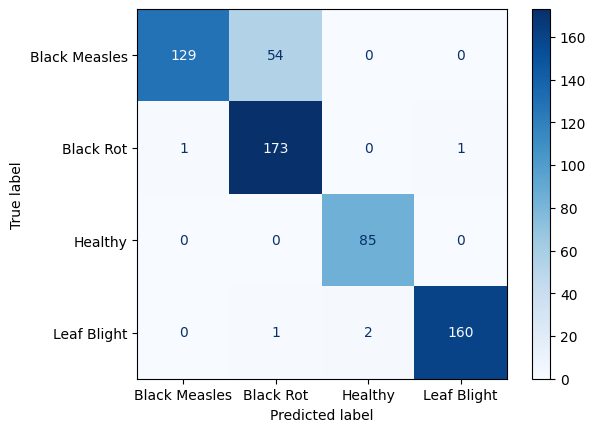

In [35]:
cm(test, CNN_2)

### 8.3 CNN_3

19/19 [==============================] - 1s 46ms/step


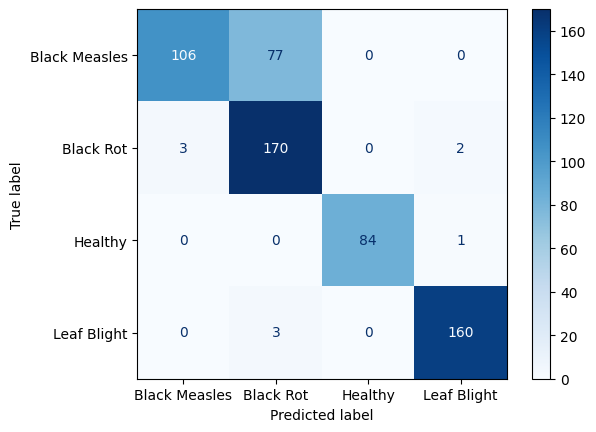

In [36]:
cm(test, CNN_3)

### 8.4 VGG16

19/19 [==============================] - 0s 3ms/step


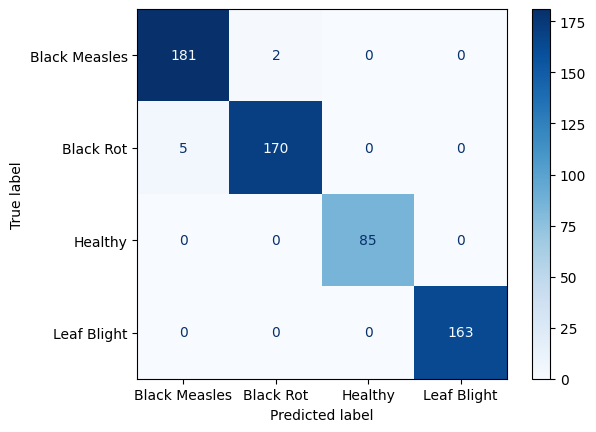

In [37]:
# code to diplay confusion matrix for VGG16
values = VGG16_model.predict(test, verbose=1)
values_flat = np.reshape(values, (values.shape[0], 8 * 8 * 512))

labels_list = []
for _, labels in test:
    labels_list.append(labels.numpy())
labels = np.concatenate(labels_list, axis=0)

predictions_VGG16 = VGG_top.predict(values_flat)
predicted_classes = np.argmax(predictions_VGG16, axis=1)
cm = confusion_matrix(labels, predicted_classes)

disp  = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Black Measles', 'Black Rot', 'Healthy', 'Leaf Blight'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks()
plt.show()

Here we can see VGG16 wrongly predicted 5 Black Rot as Black Measles and 2 Black Measles as Black Rot​. <br>
Unlike CNN_1 it predicted all diseased plants as diseased and all healthy plants as Healthy

## 9. Further Testing

The further testing dataset includes images of varying quality and backround to assess model robustness more effectively. This initial test aims to evaluate model performance in real-world scenarios and identify necessary improvements before deployment.

### 9.1 Loading Images

In [38]:
further_test = tf.keras.utils.image_dataset_from_directory('further_testing', seed=42)

Found 21 files belonging to 4 classes.


### 9.2 Evaluating Models

In [46]:
# CNN_1 further testing
CNN.evaluate(further_test)

1/1 [==============================] - 0s 250ms/step - loss: 16.3238 - accuracy: 0.2857


[16.32380485534668, 0.2857142984867096]

In [39]:
# CNN_2 further testing
CNN_2.evaluate(further_test)

1/1 [==============================] - 0s 369ms/step - loss: 9.3972 - accuracy: 0.3333


[9.397212028503418, 0.3333333432674408]

In [47]:
# CNN_3 further testing
CNN_3.evaluate(further_test)

1/1 [==============================] - 0s 97ms/step - loss: 6.0060 - accuracy: 0.4286


[6.005971431732178, 0.4285714328289032]

In [48]:
# VGG16 further testing
values = VGG16_model.predict(further_test, verbose=1)
values_flat = np.reshape(values, (values.shape[0], 8 * 8 * 512))

labels_list = []
for _, labels in further_test:
    labels_list.append(labels.numpy())
labels = np.concatenate(labels_list, axis=0)

VGG_top.evaluate(values_flat, labels)

1/1 [==============================] - 0s 25ms/step - loss: 49.7885 - accuracy: 0.2381


[49.78852081298828, 0.2380952388048172]

## 10. Visulisation

### 10.1 CNN_3 (Best Preforming Model)

In [49]:
# Save CNN_3 Predictions
CNN_predictions = CNN_3.predict(further_test)
CNN_predictions = np.argmax(CNN_predictions, axis=1)

1/1 [==============================] - 0s 86ms/step


In [53]:
# Process batches of images and labels for further_test
images = []
true_labels = []
for img_batch, label_batch in further_test:
    images.append(img_batch.numpy())
    true_labels.append(label_batch.numpy())
    
images = np.concatenate(images)
images = images.astype(np.float32) / 255.0
true_labels = np.concatenate(true_labels)

In [54]:
# Dictionary of class names
classes = {
    0: "Black Measles",
    1: "Black Rot",
    2: "Healthy",
    3: "Leaf Blight"}

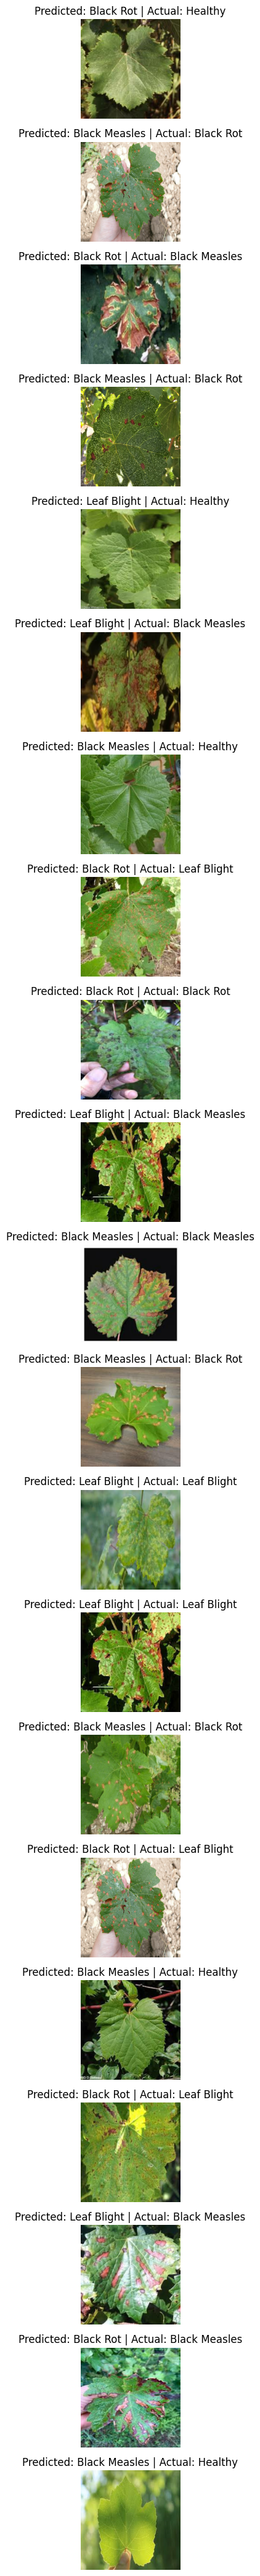

In [58]:
# Display images with predicted and actual labels
num_images = len(CNN_predictions)
plt.figure(figsize=(15, 2 * num_images))

for i in range(num_images):
    plt.subplot(num_images, 1, i + 1)
    plt.imshow(images[i])
   
    predicted_label = classes[CNN_predictions[i]]
    true_label = classes[true_labels[i]]

    plt.title(f"Predicted: {predicted_label} | Actual: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 11. Conclusion

In conclusion improving detection of diseases to minimise crop loss, reduce chemical use, and ensure high-quality grape production can be achieved by integrating convolutional neural networks (CNNs) to production. Using automated detection will support quick, informed decision making leading to streamlined disease management minimising crop losses and promoting sustainable grape production.

The outcomes of this grape disease classification project show the effectiveness and potential impact of using convolutional neural networks (CNNs) for automated plant disease detection.

Acheving 99.83% accuracy on the testing dataset indicates that it is effective at distinguishing between healthy grape leaves and the three types of diseases; grape leaf measles, grape leaf rot, and grape leaf blight.

The loss value of 0.0135 indicates that the model's predictions are very close to the actual labels, reflecting minimal errors